In [109]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

import tensorflow as tf
from tensorflow import keras

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

data = pd.read_csv("/kaggle/input/titanic/Titanic.csv")

/kaggle/input/titanic/Titanic.csv


# Начало. Анализ

посмотрим на данные которые у нас есть, что они из себя представляют. какие-то изменим для большего удобства. столбцы, которые ни как не вляют на выживаемость удалим. 

In [110]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [111]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [112]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [113]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [114]:
df = pd.DataFrame(data)
df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})

In [115]:
df = df.drop(labels = ['Ticket', 'Name', 'Embarked', 'Cabin'], axis = 1)
df = df.drop_duplicates()

сделаем карреляционную матрицу и составим несколько гипотиз

<Axes: >

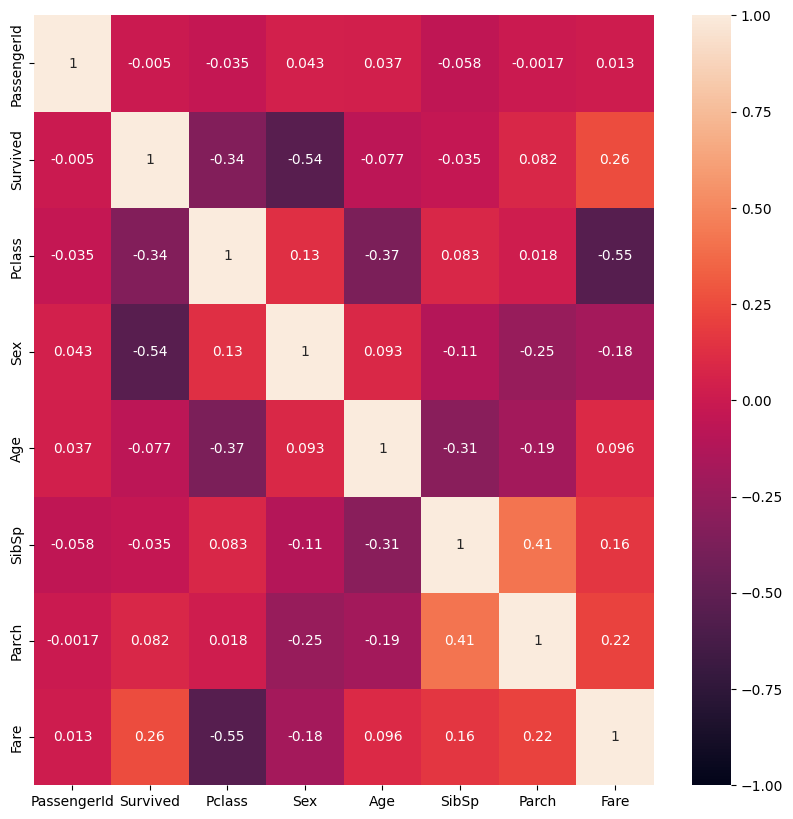

In [116]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, ax=ax)

## Гипотезы
1. Выживаемость людей зависит от пола. По моральным соображением первых спасают женщин и детей
2. Выживаемость зависит от класса, которым люди путешествовали. Первому и второму классу на титанике было легче добраться до спасательных шлюпок, чем третьему
3. выживаемость зависит от возраста человека. Принято в первую очередь спасать молодых, детей, так как у них вся жизнь впереди, зачастую даже сами старики просят себя не спасать.
4. выживаемость зависит от того, один человек путешествовал или с семьей. Выживаемсть с семьей ниже, так как люди ещё заботятся и о своих близких.

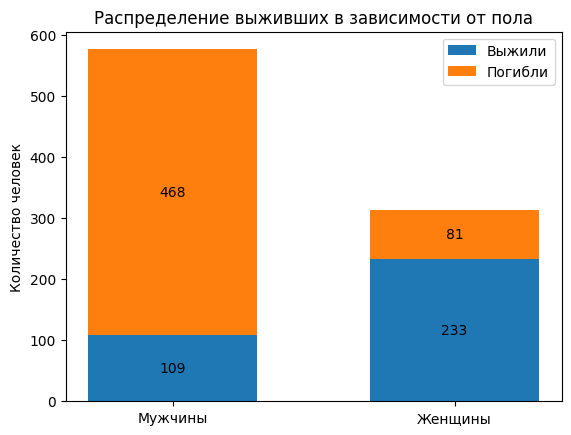

In [117]:
males_total = len(df.loc[(df['Sex'] == 1)])
females_total = len(df.loc[(df['Sex'] == 0)])
males_survived = len(df.loc[((df['Sex'] == 1) & (df['Survived'] == 1))])
females_survived = len(df.loc[((df['Sex'] == 0) & (df['Survived'] == 1))])

#Визуализируем
survivors_counts = {
    'Выжили': [males_survived, females_survived],
    'Погибли': [males_total-males_survived, females_total-females_survived]
}

fig, ax = plt.subplots()
bottom = np.zeros(2)

for key, count in survivors_counts.items():
    p = ax.bar(('Мужчины', 'Женщины'), count, width=0.6, label=key, bottom=bottom)
    bottom += count
    ax.bar_label(p, label_type='center')

ax.set_title('Распределение выживших в зависимости от пола')
ax.set_ylabel('Количество человек')
ax.legend()
plt.show()

### Вывод
Не смотря на то, что мужчин на корабле был больше, из процент выживаемсти намного меньше, чем среди женщин

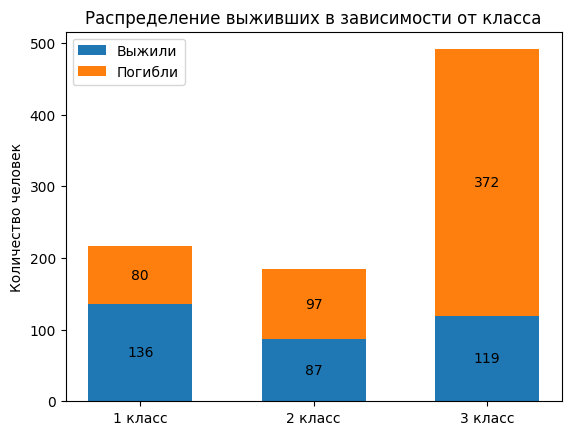

In [118]:
first_class_total = len(df.loc[(df['Pclass'] == 1)])
second_class_total = len(df.loc[(df['Pclass'] == 2)])
third_class_total = len(df.loc[(df['Pclass'] == 3)])

first_class_survived = len(df.loc[((df['Pclass'] == 1) & (df['Survived'] == 1))])
second_class_survived = len(df.loc[((df['Pclass'] == 2) & (df['Survived'] == 1))])
third_class_survived = len(df.loc[((df['Pclass'] == 3) & (df['Survived'] == 1))])

#Визуализируем
survivors_counts = {
    'Выжили': [first_class_survived, second_class_survived, third_class_survived],
    'Погибли': [first_class_total-first_class_survived, second_class_total-second_class_survived, third_class_total-third_class_survived]
}

fig, ax = plt.subplots()
bottom = np.zeros(3)

for key, count in survivors_counts.items():
    p = ax.bar(('1 класс', '2 класс', '3 класс'), count, width=0.6, label=key, bottom=bottom)
    bottom += count
    ax.bar_label(p, label_type='center')

ax.set_title('Распределение выживших в зависимости от класса')
ax.set_ylabel('Количество человек')
ax.legend()
plt.show()

### Вывод
Можем заметить, что третьего класса на корабле было больше чем первого и второго в сумме, но выживаемость в процентном соотношение у них намного меньше 

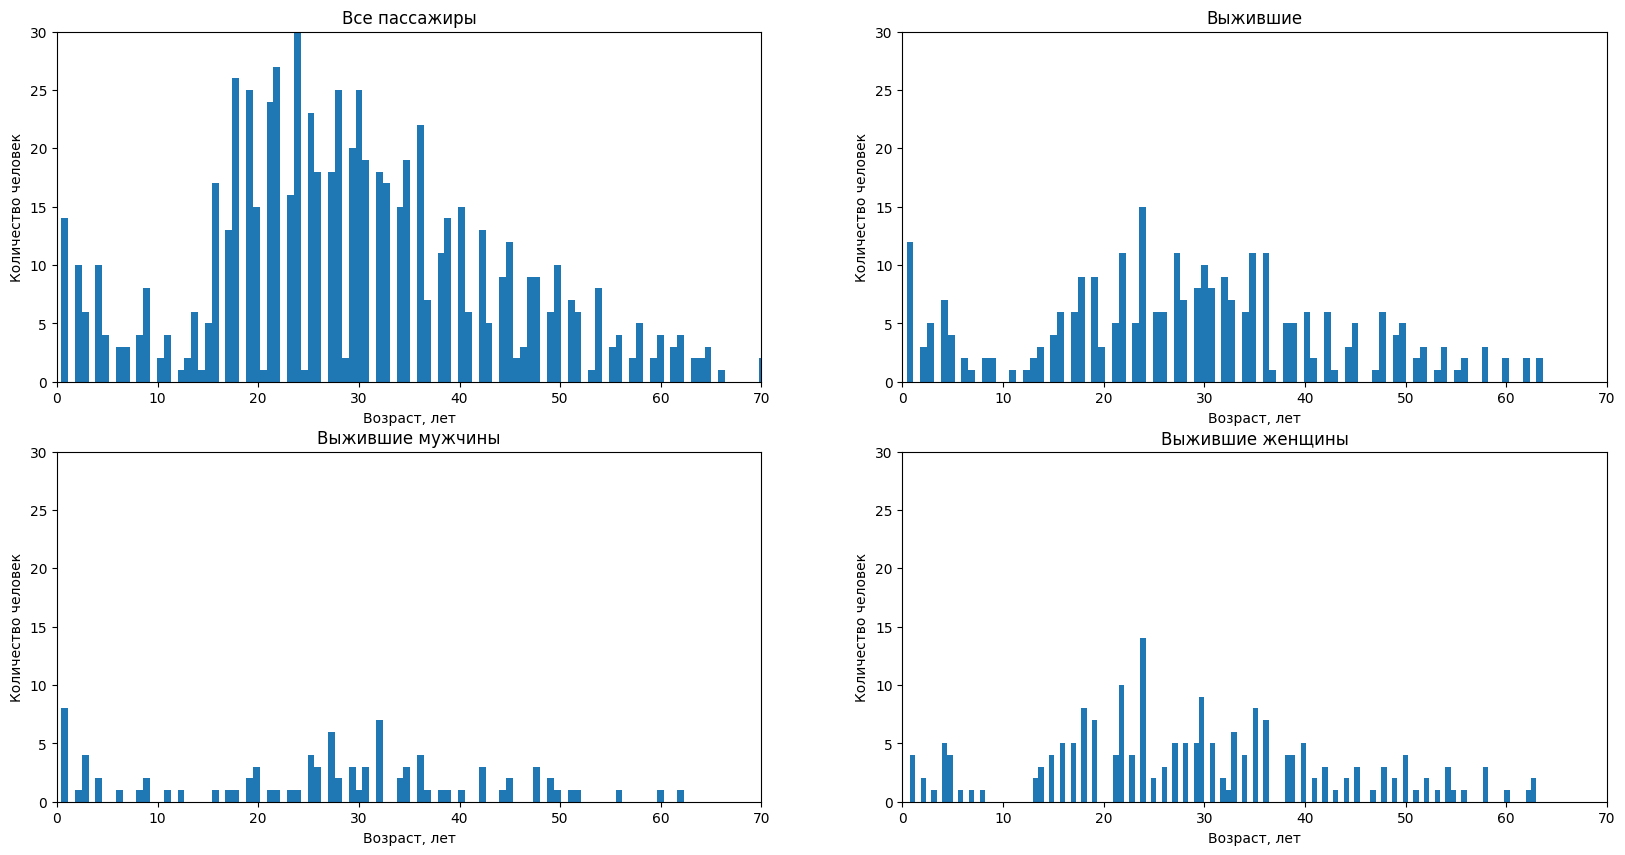

In [119]:
survivors = df.loc[(df['Survived'] == 1)]
male_survivors = df.loc[((df['Sex'] == 1) & (df['Survived'] == 1))]
female_survivors = df.loc[((df['Sex'] == 0) & (df['Survived'] == 1))]

#Число возрастов
num_of_ages = len(dict(Counter(survivors['Age'])).keys())

#Визуализируем
fig, axs = plt.subplots(2,2)
fig.set_figwidth(20)
fig.set_figheight(10)
names = [['Все пассажиры', 'Выжившие'], ['Выжившие мужчины', 'Выжившие женщины']]
for i, surv in enumerate([[df, survivors], [male_survivors, female_survivors]]):
    for j, subsurv in enumerate(surv):
        axs[i][j].hist(subsurv['Age'], bins=num_of_ages)
        axs[i][j].set_title(names[i][j])
        axs[i][j].set_xlabel('Возраст, лет')
        axs[i][j].set_ylabel('Количество человек')
        axs[i][j].set_ylim(0,30)
        axs[i][j].set_xlim(0,70)
plt.show()

In [120]:
children = df.loc[((df['Age'] < np.float64(18.0)) & (df['Age'] > 0))]
survivors_children = df.loc[((df['Age'] < np.float64(18.0)) & (df['Survived'] == 1) & (df['Age'] > 0))]
print(f'Пасажиров до 18 лет спаслось {round(len(survivors_children)*100/len(children), 2)}%')

Пасажиров до 18 лет спаслось 53.98%


<Axes: >

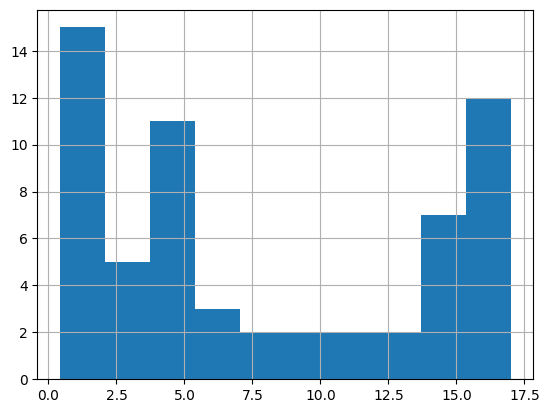

In [121]:
df.loc[((df['Survived'] == 1) & (df['Age'] > 0) & (df['Age'] < 18))].Age.hist()

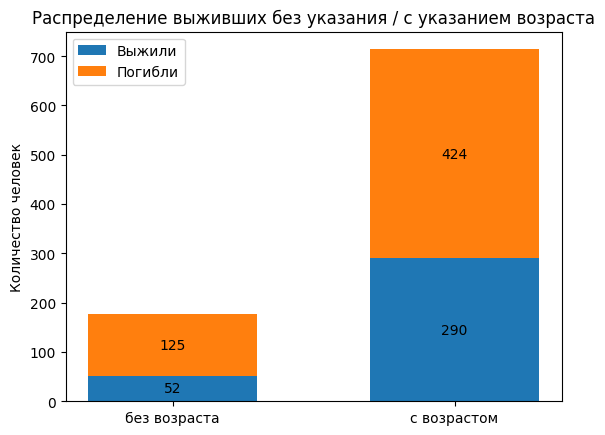

In [122]:
noage_total = len(df.loc[(pd.isna(df['Age']))])
noage_survived = len(df.loc[(pd.isna(df['Age'])) & (df['Survived'] == 1)])

age_total = len(df['Age']) - noage_total
age_survived = df[['Age', 'Survived']]
age_survived = len(df.loc[(df['Survived'] == 1)]) - noage_survived


survivors_counts = {
    'Выжили': [noage_survived, age_survived],
    'Погибли': [noage_total-noage_survived, age_total-age_survived]
}

fig, ax = plt.subplots()
bottom = np.zeros(2)
for key, count in survivors_counts.items():
    p = ax.bar(('без возраста', 'с возрастом'),count, width=0.6, label=key, bottom=bottom)
    bottom += count
    ax.bar_label(p, label_type='center')

ax.set_title('Распределение выживших без указания / с указанием возраста')
ax.set_ylabel('Количество человек')
ax.legend()
plt.show()

### Вывод
Выживаемость среди мужчин зачастую зависит от возраста, людей среднего возаста было спасего намного меньше чем остальных, среди женщин такой тендеции не наблюдается. 
Среди детей выживаесть 50%, что достаточно высоко

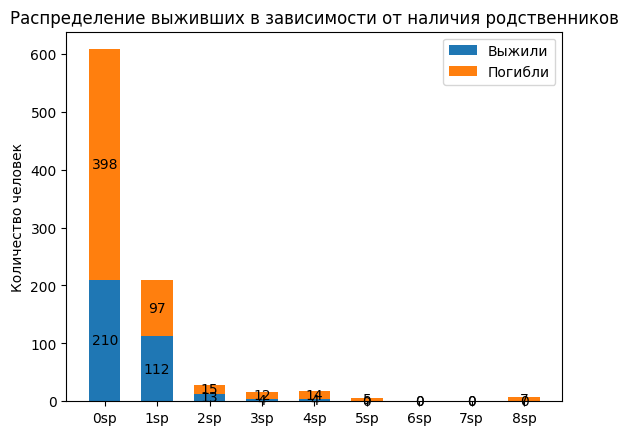

In [123]:
SibSp0_total = len(df.loc[(df['SibSp'] == 0)])
SibSp1_total = len(df.loc[(df['SibSp'] == 1)])
SibSp2_total = len(df.loc[(df['SibSp'] == 2)])
SibSp3_total = len(df.loc[(df['SibSp'] == 3)])
SibSp4_total = len(df.loc[(df['SibSp'] == 4)])
SibSp5_total = len(df.loc[(df['SibSp'] ==5)])
SibSp6_total = len(df.loc[(df['SibSp'] == 6)])
SibSp7_total = len(df.loc[(df['SibSp'] == 7)])
SibSp8_total = len(df.loc[(df['SibSp'] == 8)])

SibSp0_survived = len(df.loc[((df['SibSp'] == 0) & (df['Survived'] == 1))])
SibSp1_survived = len(df.loc[((df['SibSp'] == 1) & (df['Survived'] == 1))])
SibSp2_survived = len(df.loc[((df['SibSp'] == 2) & (df['Survived'] == 1))])
SibSp3_survived = len(df.loc[((df['SibSp'] == 3) & (df['Survived'] == 1))])
SibSp4_survived = len(df.loc[((df['SibSp'] == 3) & (df['Survived'] == 1))])
SibSp5_survived = len(df.loc[((df['SibSp'] == 5) & (df['Survived'] == 1))])
SibSp6_survived = len(df.loc[((df['SibSp'] == 6) & (df['Survived'] == 1))])
SibSp7_survived = len(df.loc[((df['SibSp'] == 7) & (df['Survived'] == 1))])
SibSp8_survived = len(df.loc[((df['SibSp'] == 8) & (df['Survived'] == 1))])

#Визуализируем
survivors_counts = {
    'Выжили': [SibSp0_survived, 
               SibSp1_survived, 
               SibSp2_survived, 
               SibSp3_survived, 
               SibSp4_survived, 
               SibSp5_survived, 
               SibSp6_survived, 
               SibSp7_survived, 
               SibSp8_survived],
    'Погибли': [SibSp0_total-SibSp0_survived, 
                SibSp1_total-SibSp1_survived,  
                SibSp2_total-SibSp2_survived, 
                SibSp3_total-SibSp3_survived, 
                SibSp4_total-SibSp4_survived, 
                SibSp5_total-SibSp5_survived, 
                SibSp6_total-SibSp6_survived, 
                SibSp7_total-SibSp7_survived, 
                SibSp8_total-SibSp8_survived]
}

fig, ax = plt.subplots()
bottom = np.zeros(9)

for key, count in survivors_counts.items():
    p = ax.bar(('0sp', '1sp', '2sp', '3sp', '4sp', '5sp', '6sp', '7sp', '8sp'), count, width=0.6, label=key, bottom=bottom)
    bottom += count
    ax.bar_label(p, label_type='center')

ax.set_title('Распределение выживших в зависимости от наличия родственников')
ax.set_ylabel('Количество человек')
ax.legend()
plt.show()

### Вывод
Выживаение среди людей, которые путешестввали одни или только с одним или двумя членами семьи, чем у тех, кто путешестввал с большм количеством родственников

# Модель

In [124]:
df = df.dropna()

In [125]:
X = df.drop(columns=['Survived'])  
y = df['Survived']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'test Loss {loss}')

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3019 - val_loss: 0.1973
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1648 - val_loss: 0.1754
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1302 - val_loss: 0.1543
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1424 - val_loss: 0.1532
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1367 - val_loss: 0.1526
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1363 - val_loss: 0.1495
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1165 - val_loss: 0.1491
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1185 - val_loss: 0.1456
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1176 - val_loss: 0.1435
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0962 - val_loss: 0.1455
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1606 
test Loss 0.1593838334083557


In [126]:
y_pred = model.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f'MAE {mae}')
print(f'MSE {mse}')
print(f'RMSE {rmse}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MAE 0.2990744528393229
MSE 0.15938384866740263
RMSE 0.39922906791390156
